In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
    #for filename in filenames:
        #print(os.path.join(dirname, filename))
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
#from keras.preprocessing.image import ImageDataGenerator, load_img
import keras
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten,Dense,Dropout,BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from tensorflow.keras.applications import VGG16, InceptionResNetV2
from keras import regularizers
from keras.utils import plot_model
from keras.optimizers import Adam, RMSprop, SGD
from keras.callbacks import ModelCheckpoint, CSVLogger, TensorBoard, EarlyStopping, ReduceLROnPlateau
import datetime

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
! pip install kaggle
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d msambare/fer2013
!unzip fer2013.zip


#read images 

In [ ]:
train_dir = 'train/'
test_dir = 'test/'
row, col = 48, 48
classes = 7

def count_exp(path, set_):
    dict_ = {}
    for expression in os.listdir(path):
        dir_ = path + expression
        dict_[expression] = len(os.listdir(dir_))
    df = pd.DataFrame(dict_, index=[set_])
    return df
train_count = count_exp(train_dir, 'train')
test_count = count_exp(test_dir, 'test')
print(train_count)
print(test_count)

       angry  disgust  neutral  happy  surprise  fear   sad
train   3995      436     4965   7215      3171  4097  4830
      angry  disgust  neutral  happy  surprise  fear   sad
test    958      111     1233   1774       831  1024  1247


In [ ]:
# cound

#count number of images per class

<Axes: >

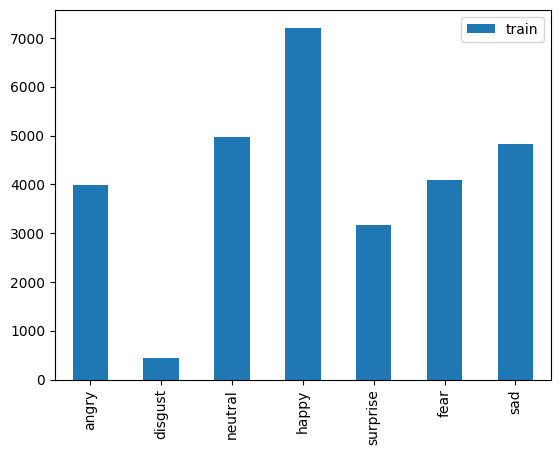

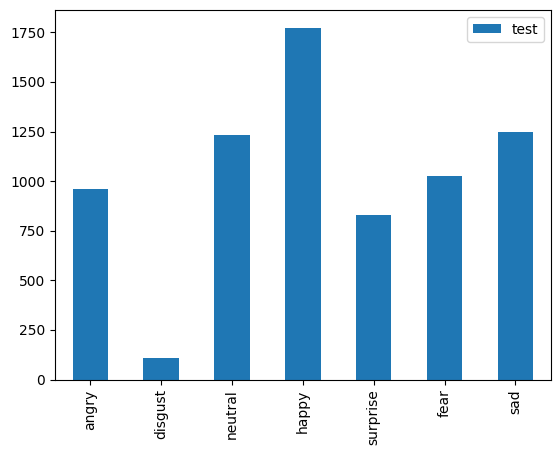

In [ ]:
train_count.transpose().plot(kind='bar')
test_count.transpose().plot(kind='bar')

#show some images

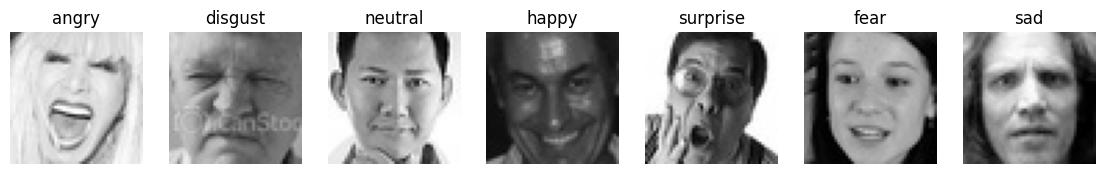

In [ ]:
plt.figure(figsize=(14,22))
i = 1
for expression in os.listdir(train_dir):
    img = cv2.imread((train_dir + expression +'/'+ os.listdir(train_dir + expression)[1]))
    plt.subplot(1,7,i)
    plt.imshow(img)
    plt.title(expression)
    plt.axis('off')
    i += 1
plt.show()

#read images by using ImageDataGenerator

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3,horizontal_flip=True)

training_set = train_datagen.flow_from_directory(train_dir,batch_size=64,
                                                target_size=(48,48),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1./255)
test_set = test_datagen.flow_from_directory(test_dir,
                                                batch_size=64,
                                                target_size=(48,48),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical')

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


#classes 


In [ ]:
training_set.class_indices

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

#First model :VGG

In [ ]:
def get_model(input_size, classes=7):
     #Initialising the CNN
    model = tf.keras.models.Sequential()   

    model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape =input_size))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)))
    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(classes, activation='softmax'))

    #Compliling the model
    model.compile(optimizer=Adam(lr=0.0001, decay=1e-6), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

In [ ]:
fernet = get_model((row,col,1), classes)
fernet.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 128)       7

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


# model architecture 

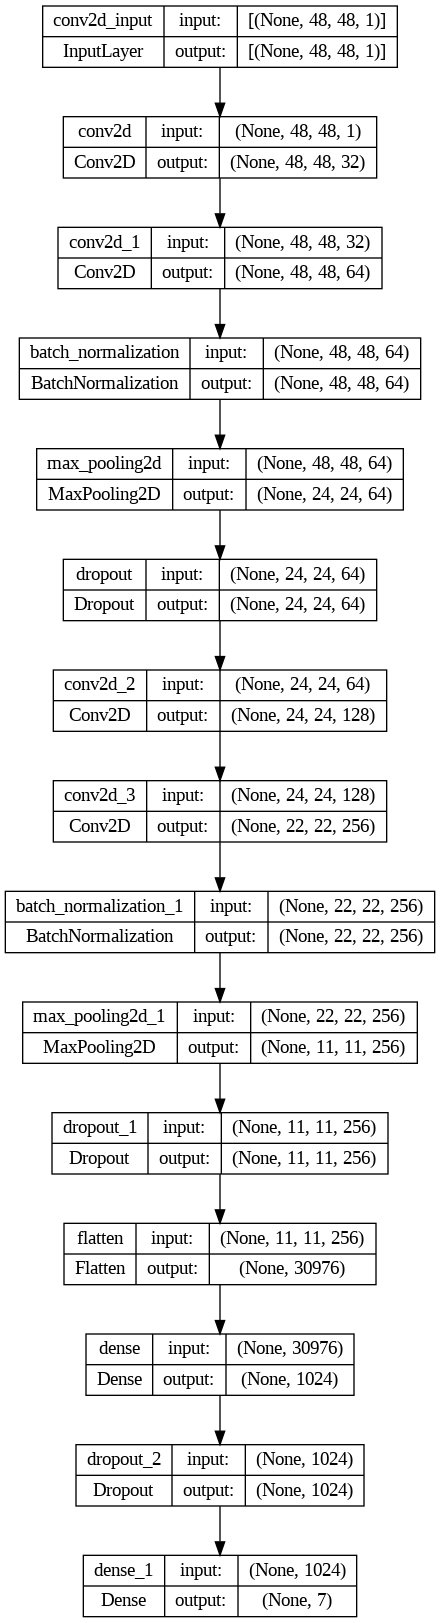

In [ ]:
plot_model(fernet, to_file='fernet.png', show_shapes=True, show_layer_names=True)

# defines Callbacks

In [ ]:
chk_path = 'ferNet.h5'
log_dir = "checkpoint/logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
#save model after some epoches 
checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             moniter='val_loss')

# stop when there no progress
earlystop = EarlyStopping(monitor='val_loss', 
                          min_delta=0, 
                          patience=3, 
                          verbose=1, 
                          restore_best_weights=True)
# reduce learning rate when after some epoch                        
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.2, 
                              patience=6, 
                              verbose=1, 
                              min_delta=0.0001)


tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
csv_logger = CSVLogger('training.log')

callbacks = [checkpoint, reduce_lr, csv_logger]

#train model

In [ ]:
steps_per_epoch = training_set.n // training_set.batch_size
validation_steps = test_set.n // test_set.batch_size

hist = fernet.fit(x=training_set,
                 validation_data=test_set,
                 epochs=60,
                 callbacks=callbacks,
                 steps_per_epoch=steps_per_epoch,
                 validation_steps=validation_steps,batch_size=32)

448/448 [==============================] - ETA: 0s - loss: 2.9416 - accuracy: 0.3704
Epoch 3: val_loss improved from 3.12980 to 2.67904, saving model to ferNet.h5
448/448 [==============================] - 34s 75ms/step - loss: 2.9416 - accuracy: 0.3704 - val_loss: 2.6790 - val_accuracy: 0.4095 - lr: 1.0000e-04
Epoch 4/60
448/448 [==============================] - ETA: 0s - loss: 2.5366 - accuracy: 0.4001
Epoch 4: val_loss improved from 2.67904 to 2.26932, saving model to ferNet.h5
448/448 [==============================] - 30s 67ms/step - loss: 2.5366 - accuracy: 0.4001 - val_loss: 2.2693 - val_accuracy: 0.4474 - lr: 1.0000e-04
Epoch 5/60
448/448 [==============================] - ETA: 0s - loss: 2.2177 - accuracy: 0.4286
Epoch 5: val_loss improved from 2.26932 to 1.97862, saving model to ferNet.h5
448/448 [==============================] - 30s 66ms/step - loss: 2.2177 - accuracy: 0.4286 - val_loss: 1.9786 - val_accuracy: 0.4700 - lr: 1.0000e-04
Epoch 6/60
448/448 [===================

In [ ]:
fernet.save('fernet.h5')

#  visual train steps 

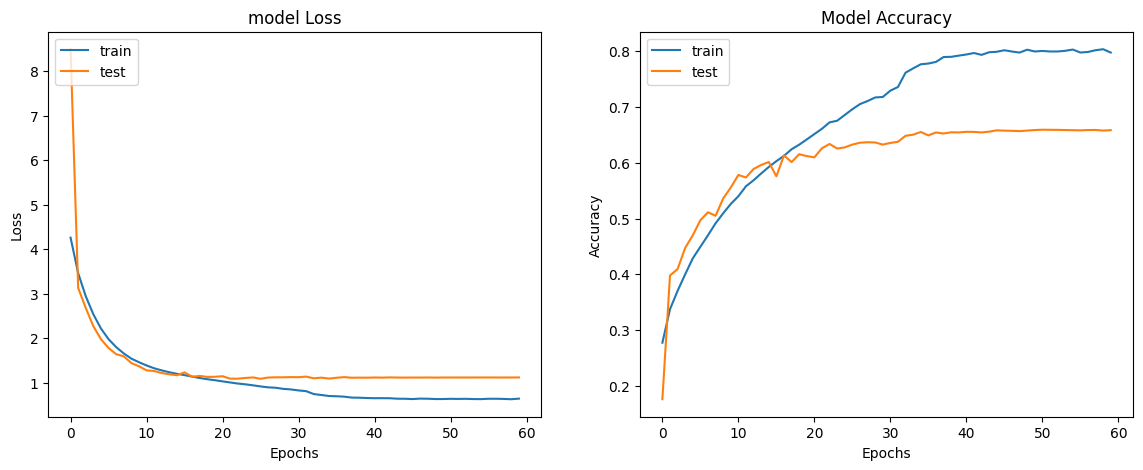

In [ ]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,2)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(1,2,1)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
def vgg16_model(input_size, classes=7):
     #Initialising the CNN
    model = tf.keras.models.Sequential()   

    model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape =input_size))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(96, kernel_size=(3, 3), padding='same', activation='relu', input_shape =input_size))
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    
    model.add(Conv2D(96, kernel_size=(3, 3), padding='same', activation='relu', input_shape =input_size))
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(96, kernel_size=(3, 3), padding='same', activation='relu', input_shape =input_size))
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(0.25))

    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)))
    model.add(Conv2D(512, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(classes, activation='softmax'))

    #Compliling the model
    model.compile(optimizer=Adam(lr=0.0001, decay=1e-6), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

#define model

In [ ]:
fernet1 = vgg16_model((row,col,1), classes)
fernet1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 48, 48, 32)        320       
                                                                 
 conv2d_9 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 batch_normalization_4 (Batc  (None, 48, 48, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 24, 24, 64)       0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 24, 24, 64)        0         
                                                                 
 conv2d_10 (Conv2D)          (None, 24, 24, 96)       

#visual model architecture

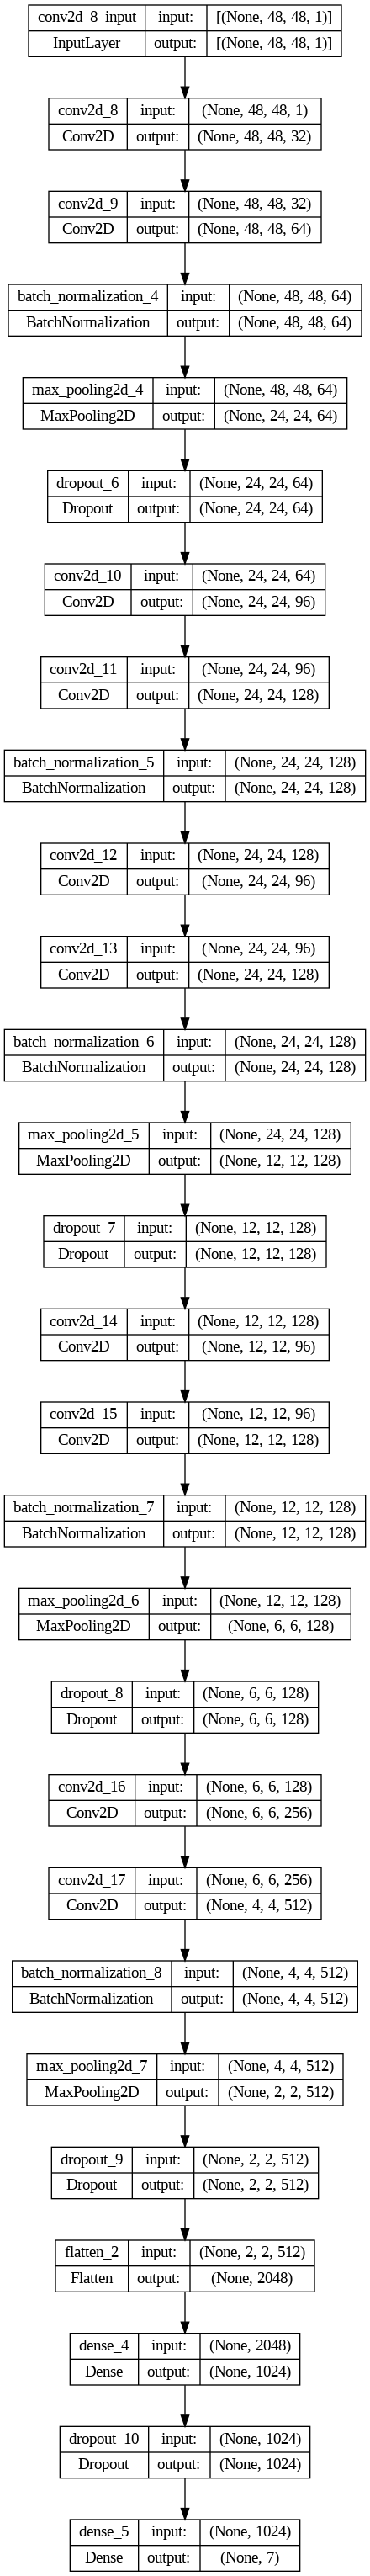

In [ ]:
plot_model(fernet1, to_file='fernet.png', show_shapes=True, show_layer_names=True)

#Train the model

In [ ]:
steps_per_epoch = training_set.n // training_set.batch_size
validation_steps = test_set.n // test_set.batch_size

hist = fernet1.fit(x=training_set,
                 validation_data=test_set,
                 epochs=60,
                 callbacks=callbacks,
                 steps_per_epoch=steps_per_epoch,
                 validation_steps=validation_steps,batch_size=32)

Epoch 1/60
448/448 [==============================] - ETA: 0s - loss: 6.9282 - accuracy: 0.2261
Epoch 1: val_loss did not improve from 1.64109
448/448 [==============================] - 34s 72ms/step - loss: 6.9282 - accuracy: 0.2261 - val_loss: 12.4549 - val_accuracy: 0.1424 - lr: 1.0000e-04
Epoch 2/60
448/448 [==============================] - ETA: 0s - loss: 5.7815 - accuracy: 0.2564
Epoch 2: val_loss did not improve from 1.64109
448/448 [==============================] - 30s 66ms/step - loss: 5.7815 - accuracy: 0.2564 - val_loss: 5.5417 - val_accuracy: 0.2847 - lr: 1.0000e-04
Epoch 3/60
448/448 [==============================] - ETA: 0s - loss: 4.8358 - accuracy: 0.2958
Epoch 3: val_loss did not improve from 1.64109
448/448 [==============================] - 29s 64ms/step - loss: 4.8358 - accuracy: 0.2958 - val_loss: 4.7892 - val_accuracy: 0.3015 - lr: 1.0000e-04
Epoch 4/60
448/448 [==============================] - ETA: 0s - loss: 4.0036 - accuracy: 0.3246
Epoch 4: val_loss did no

#visual the progress and train

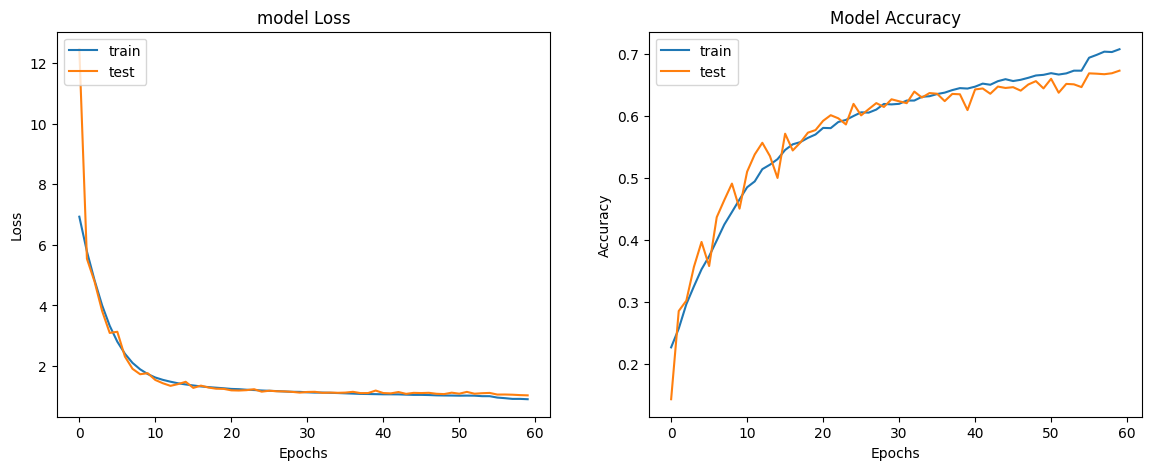

In [ ]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,2)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(1,2,1)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#make alexnet model

In [ ]:
def Alex_model(input_size, classes=7):
    model = Sequential()

    # Layer 1: Convolutional Layer with 96 filters, kernel size of 11x11, and stride of 4x4
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_size))

    # Layer 2: Max Pooling Layer with a pool size of 3x3 and stride of 2x2
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # Layer 3: Convolutional Layer with 256 filters, kernel size of 5x5, and stride of 1x1
    model.add(Conv2D(256, (3, 3), activation='relu'))

    # Layer 4: Max Pooling Layer with a pool size of 3x3 and stride of 2x2
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # Layer 5: Convolutional Layer with 384 filters, kernel size of 3x3, and stride of 1x1
    model.add(Conv2D(384, (3, 3), activation='relu'))

    # Layer 6: Convolutional Layer with 384 filters, kernel size of 3x3, and stride of 1x1
    model.add(Conv2D(384, (3, 3), activation='relu'))

    # Layer 7: Convolutional Layer with 256 filters, kernel size of 3x3, and stride of 1x1
    model.add(Conv2D(256, (3, 3), activation='relu'))

    # Layer 8: Max Pooling Layer with a pool size of 3x3 and stride of 2x2
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # Layer 9: Flatten Layer to convert the 2D feature maps to a 1D feature vector
    model.add(Flatten())

    # Layer 10: Fully Connected Layer with 4096 units
    model.add(Dense(4096, activation='relu'))

    # Layer 11: Dropout Layer to prevent overfitting
    model.add(Dropout(0.5))

    # Layer 12: Fully Connected Layer with 4096 units
    model.add(Dense(4096, activation='relu'))

    # Layer 13: Dropout Layer to prevent overfitting
    model.add(Dropout(0.5))

    # Layer 14: Output Layer with num_classes units and softmax activation for classification
    model.add(Dense(classes, activation='softmax'))

    #Compliling the model
    model.compile(optimizer=Adam(lr=0.0001, decay=1e-6), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

#define model

In [ ]:
fernet2 = Alex_model((row,col,1), classes)
fernet2.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_94 (Conv2D)          (None, 46, 46, 32)        320       
                                                                 
 max_pooling2d_51 (MaxPoolin  (None, 23, 23, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_95 (Conv2D)          (None, 21, 21, 256)       73984     
                                                                 
 max_pooling2d_52 (MaxPoolin  (None, 10, 10, 256)      0         
 g2D)                                                            
                                                                 
 conv2d_96 (Conv2D)          (None, 8, 8, 384)         885120    
                                                                 
 conv2d_97 (Conv2D)          (None, 6, 6, 384)       

#visualize model architecture

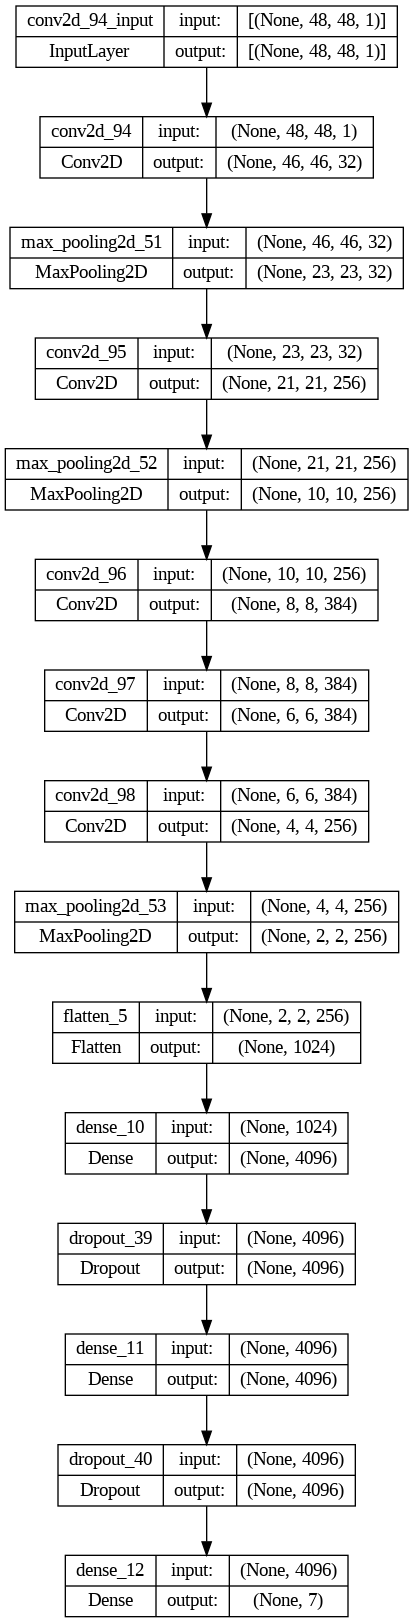

In [ ]:
plot_model(fernet2, to_file='fernet.png', show_shapes=True, show_layer_names=True)

In [ ]:
chk_path = 'ferNet2.h5'
log_dir = "checkpoint/logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             moniter='val_loss')

earlystop = EarlyStopping(monitor='val_loss', 
                          min_delta=0, 
                          patience=3, 
                          verbose=1, 
                          restore_best_weights=True)
                        
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.2, 
                              patience=6, 
                              verbose=1, 
                              min_delta=0.0001)


tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
csv_logger = CSVLogger('training.log')

callbacks = [checkpoint, reduce_lr, csv_logger]

#train model

In [ ]:
steps_per_epoch = training_set.n // training_set.batch_size
validation_steps = test_set.n // test_set.batch_size

hist = fernet2.fit(x=training_set,
                 validation_data=test_set,
                 epochs=60,
                 callbacks=callbacks,
                 steps_per_epoch=steps_per_epoch,
                 validation_steps=validation_steps,batch_size=32)

Epoch 1/60
447/448 [============================>.] - ETA: 0s - loss: 1.8106 - accuracy: 0.2518
Epoch 1: val_loss improved from inf to 1.74570, saving model to ferNet2.h5
448/448 [==============================] - 44s 95ms/step - loss: 1.8104 - accuracy: 0.2518 - val_loss: 1.7457 - val_accuracy: 0.2803 - lr: 1.0000e-04
Epoch 2/60
448/448 [==============================] - ETA: 0s - loss: 1.6607 - accuracy: 0.3364
Epoch 2: val_loss improved from 1.74570 to 1.50372, saving model to ferNet2.h5
448/448 [==============================] - 26s 59ms/step - loss: 1.6607 - accuracy: 0.3364 - val_loss: 1.5037 - val_accuracy: 0.4201 - lr: 1.0000e-04
Epoch 3/60
448/448 [==============================] - ETA: 0s - loss: 1.5273 - accuracy: 0.4080
Epoch 3: val_loss improved from 1.50372 to 1.42767, saving model to ferNet2.h5
448/448 [==============================] - 32s 72ms/step - loss: 1.5273 - accuracy: 0.4080 - val_loss: 1.4277 - val_accuracy: 0.4449 - lr: 1.0000e-04
Epoch 4/60
447/448 [=========

#visualize train phase

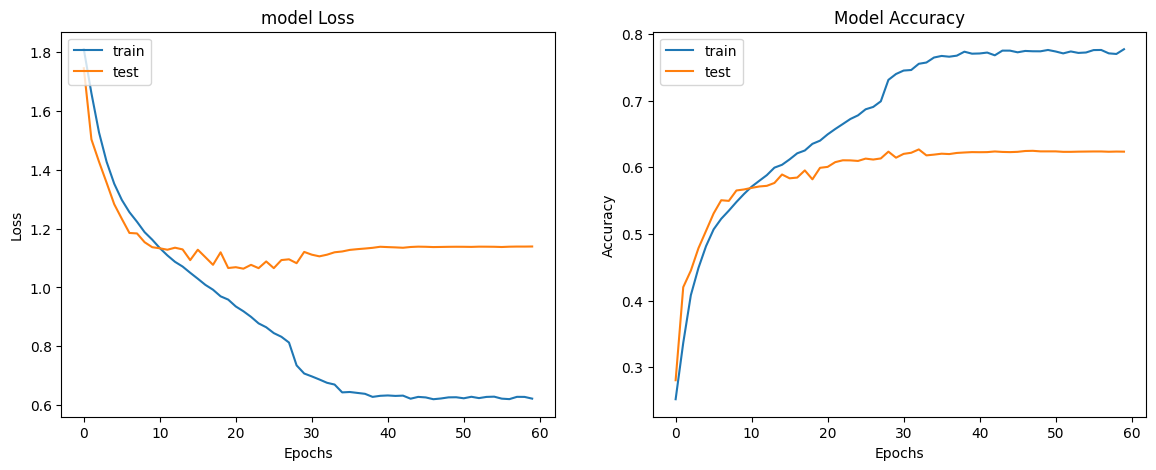

In [ ]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,2)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(1,2,1)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#define model

In [ ]:
def inception_model(input_size, classes=7):
     #Initialising the CNN
    model = tf.keras.models.Sequential()   

    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(96, kernel_size=(3, 3), padding='same', activation='relu', input_shape =input_size))
    model.add(Conv2D(96, kernel_size=(3, 3), padding='same', activation='relu', input_shape =input_size))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2, 2))
    
    model.add(Conv2D(96, kernel_size=(3, 3), padding='same', activation='relu', input_shape =input_size))
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu', input_shape =input_size))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(0.25))

    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)))
    model.add(Conv2D(512, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(classes, activation='softmax'))

    #Compliling the model
    model.compile(optimizer=Adam(lr=0.0001, decay=1e-6), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

In [ ]:
fernet3 = inception_model((row,col,1), classes)
fernet3.summary()

visual model architecture

In [ ]:
plot_model(fernet3, to_file='fernet.png', show_shapes=True, show_layer_names=True)

ValueError: ignored

In [ ]:
chk_path = 'ferNet3.h5'
log_dir = "checkpoint/logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             moniter='val_loss')

earlystop = EarlyStopping(monitor='val_loss', 
                          min_delta=0, 
                          patience=3, 
                          verbose=1, 
                          restore_best_weights=True)
                        
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.2, 
                              patience=6, 
                              verbose=1, 
                              min_delta=0.0001)


tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
csv_logger = CSVLogger('training.log')

callbacks = [checkpoint, reduce_lr, csv_logger]

# train model

In [ ]:
steps_per_epoch = training_set.n // training_set.batch_size
validation_steps = test_set.n // test_set.batch_size

hist = fernet3.fit(x=training_set,
                 validation_data=test_set,
                 epochs=60,
                 callbacks=callbacks,
                 steps_per_epoch=steps_per_epoch,
                 validation_steps=validation_steps,batch_size=32)

#visual model train phase

In [ ]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,2)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(1,2,1)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
import numpy as np
from sklearn.metrics import classification_report

# Assuming you have trained your neural network model and obtained predictions

y_true = test_set.classes  # True labels of test data
y_pred_probabilities = fernet.predict(test_set)  # Predicted probabilities using your model

# Convert predicted probabilities to class labels
y_pred_labels = np.argmax(y_pred_probabilities, axis=1)

# Generate the classification report
report = classification_report(y_true, y_pred_labels, target_names=test_set.class_indices)

# Print the report
print(report)

113/113 [==============================] - 3s 23ms/step
              precision    recall  f1-score   support

       angry       0.14      0.15      0.14       958
     disgust       0.02      0.01      0.01       111
        fear       0.13      0.11      0.12      1024
       happy       0.23      0.23      0.23      1774
     neutral       0.17      0.19      0.18      1233
         sad       0.20      0.19      0.19      1247
    surprise       0.10      0.10      0.10       831

    accuracy                           0.17      7178
   macro avg       0.14      0.14      0.14      7178
weighted avg       0.17      0.17      0.17      7178



In [ ]:
import numpy as np
from sklearn.metrics import classification_report

# Assuming you have trained your neural network model and obtained predictions

y_true = test_set.classes  # True labels of test data
y_pred_probabilities = fernet1.predict(test_set)  # Predicted probabilities using your model

# Convert predicted probabilities to class labels
y_pred_labels = np.argmax(y_pred_probabilities, axis=1)

# Generate the classification report
report = classification_report(y_true, y_pred_labels, target_names=test_set.class_indices)

# Print the report
print(report)

113/113 [==============================] - 3s 25ms/step
              precision    recall  f1-score   support

       angry       0.13      0.13      0.13       958
     disgust       0.02      0.02      0.02       111
        fear       0.13      0.09      0.11      1024
       happy       0.25      0.26      0.26      1774
     neutral       0.17      0.20      0.19      1233
         sad       0.17      0.16      0.16      1247
    surprise       0.12      0.13      0.12       831

    accuracy                           0.17      7178
   macro avg       0.14      0.14      0.14      7178
weighted avg       0.17      0.17      0.17      7178



In [ ]:
import numpy as np
from sklearn.metrics import classification_report

# Assuming you have trained your neural network model and obtained predictions

y_true = test_set.classes  # True labels of test data
y_pred_probabilities = fernet2.predict(test_set)  # Predicted probabilities using your model

# Convert predicted probabilities to class labels
y_pred_labels = np.argmax(y_pred_probabilities, axis=1)

# Generate the classification report
report = classification_report(y_true, y_pred_labels, target_names=test_set.class_indices)

# Print the report
print(report)

113/113 [==============================] - 3s 23ms/step
              precision    recall  f1-score   support

       angry       0.12      0.13      0.12       958
     disgust       0.00      0.00      0.00       111
        fear       0.15      0.15      0.15      1024
       happy       0.25      0.24      0.25      1774
     neutral       0.16      0.17      0.16      1233
         sad       0.17      0.17      0.17      1247
    surprise       0.12      0.12      0.12       831

    accuracy                           0.17      7178
   macro avg       0.14      0.14      0.14      7178
weighted avg       0.17      0.17      0.17      7178



In [ ]:
import numpy as np
from sklearn.metrics import classification_report

# Assuming you have trained your neural network model and obtained predictions

y_true = test_set.classes  # True labels of test data
y_pred_probabilities = fernet3.predict(test_set)  # Predicted probabilities using your model

# Convert predicted probabilities to class labels
y_pred_labels = np.argmax(y_pred_probabilities, axis=1)

# Generate the classification report
report = classification_report(y_true, y_pred_labels, target_names=test_set.class_indices)

# Print the report
print(report)